In [ ]:
pip install harmony

In [ ]:
# pip install requests python-dateutil
import requests, json
from datetime import datetime, timezone
from dateutil import parser as dtparser

# 1) Parâmetros de consulta
lon, lat = -104.676, 39.856  # EUA (ex.: Denver)
when_iso = "2024-07-24T14:00:00Z"  # horário alvo (UTC ISO 8601)

# Converte ISO -> epoch ms (ArcGIS time params usam milissegundos)
def to_epoch_ms(dt_str):
    t = dtparser.parse(dt_str).astimezone(timezone.utc)
    return int(t.timestamp() * 1000)

t_ms = to_epoch_ms(when_iso)

# Janela curta (±15 min) para garantir captura do scan
start_ms = t_ms - 15*60*1000
end_ms   = t_ms + 15*60*1000

# 2) URL do ImageServer O3 (pegue na página do item “TEMPO Total Column Ozone …”)
# Ex.: https://gis.earthdata.nasa.gov/image/rest/services/<COLLECTION_ID>/TEMPO_O3TOT_L3_V03_HOURLY_TOTAL_COLUMN/ImageServer
OZONE_IMAGE_SERVER = "https://gis.earthdata.nasa.gov/image/rest/services/C2930764281-LARC_CLOUD/TEMPO_O3TOT_L3_V03_HOURLY_TOTAL_COLUMN/ImageServer"

# 3) Monta chamada /getSamples
params = {
    "geometry": f"{lon},{lat}",
    "geometryType": "esriGeometryPoint",
    # Nome da variável dentro do serviço (ex.: "Total_Ozone" ou similar; veja na página REST do serviço)
    "mosaicRule": json.dumps({
        "multidimensionalDefinition": [{"variableName": "Total_Ozone"}]
    }),
    # Interpolação bilinear -> estimativa suave (média local dos vizinhos)
    "interpolation": "RSP_BilinearInterpolation",
    # intervalo de tempo
    "time": f"{start_ms},{end_ms}",
    "f": "json"
}

resp = requests.get(f"{OZONE_IMAGE_SERVER}/getSamples", params=params, timeout=60)
resp.raise_for_status()
payload = resp.json()

# 4) Extrai o(s) valor(es)
vals = []
for s in payload.get("samples", []):
    attrs = s.get("attributes", {})
    # ajuste o nome do campo se necessário (veja a página REST -> "Fields")
    for k, v in attrs.items():
        if k.lower().startswith("total") or "ozone" in k.lower():
            if v is not None:
                vals.append(float(v))

if not vals:
    raise RuntimeError("Sem valores para este ponto/tempo (fora de cobertura, noturno, sob nuvem espessa, etc.).")

# Se vierem múltiplos frames dentro da janela, faça média temporal
mean_o3 = sum(vals)/len(vals)
print(f"O3 médio (ArcGIS, ponto/tempo): {mean_o3}")


RuntimeError: Sem valores para este ponto/tempo (fora de cobertura, noturno, sob nuvem espessa, etc.).

In [ ]:
from __future__ import annotations
from datetime import date, datetime
from typing import Union
import requests

def get_t2m_celsius(lat: float, lon: float, when: Union[date, datetime, str], timeout: float = 15.0) -> float:
    """
    Retorna o valor diário de T2M (Temperatura a 2 m, em °C) da NASA POWER para uma
    latitude/longitude e data específicas.

    Parâmetros
    ----------
    lat : float
        Latitude em graus decimais (ex.: -16.71)
    lon : float
        Longitude em graus decimais (ex.: -49.26)
    when : date | datetime | str
        Data desejada. Pode ser:
          - date/datetime do Python; ou
          - string no formato 'YYYYMMDD' ou 'YYYY-MM-DD'.
    timeout : float
        Timeout em segundos para a requisição HTTP (default: 15.0)

    Retorna
    -------
    float
        Valor de T2M em graus Celsius para o dia solicitado.

    Exceções
    --------
    ValueError
        - Se não existir dado para a data informada.
        - Se a resposta da API não contiver T2M.
    requests.HTTPError
        - Se a resposta HTTP vier com status de erro.
    """

    # Normaliza a data para 'YYYYMMDD'
    if isinstance(when, (date, datetime)):
        when_str = when.strftime("%Y%m%d")
    elif isinstance(when, str):
        # aceita 'YYYY-MM-DD' ou 'YYYYMMDD'
        digits = when.replace("-", "")
        if len(digits) != 8 or not digits.isdigit():
            raise ValueError("Formato de data inválido. Use date/datetime ou string 'YYYYMMDD'/'YYYY-MM-DD'.")
        when_str = digits
    else:
        raise ValueError("Parâmetro 'when' deve ser date, datetime ou string.")

    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "latitude": lat,
        "longitude": lon,
        "parameters": "T2M",
        "start": when_str,
        "end": when_str,
        "format": "JSON",
        "community": "AG",
    }

    r = requests.get(base_url, params=params, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    try:
        value = j["properties"]["parameter"]["T2M"][when_str]
    except KeyError:
        # Monta uma mensagem amigável com o que veio de metadados, se existir
        meta = j.get("messages") or j.get("header", {}).get("message") or []
        hint = f" Detalhes: {meta}" if meta else ""
        raise ValueError(f"Não há T2M disponível para {when_str} em ({lat}, {lon}).{hint}")

    if value is None:
        raise ValueError(f"T2M veio como None para {when_str} em ({lat}, {lon}).")

    try:
        return float(value)
    except (TypeError, ValueError):
        raise ValueError(f"Não foi possível converter T2M='{value}' para float.")


In [ ]:
t2m = get_t2m_celsius(-16.71, -49.26, "2024-10-10")

In [ ]:
t2m

28.87

In [ ]:
from __future__ import annotations
from datetime import datetime, date, timedelta
from typing import Union, List, Dict, Optional
import requests

def get_power_last_90h(
    lat: float,
    lon: float,
    when: Union[datetime, str],
    *,
    time_standard: str = "LST",   # "LST" (padrão do POWER) ou "UTC"
    community: str = "AG",
    timeout: float = 20.0,
) -> List[Dict[str, Optional[float]]]:
    """
    Busca no NASA POWER (Hourly) as últimas 90 horas antes de 'when' para:
      - T2M (°C, Temperatura a 2 m)
      - RH2M (% , Umidade Relativa a 2 m)
      - WS10M (m/s, Velocidade do vento a 10 m)
      - DTR (°C, Amplitude Térmica Diurna = T2M_MAX - T2M_MIN do dia)
      - SO2 (placeholder: None, pois o POWER não fornece SO₂)

    Parâmetros
    ----------
    lat, lon : float
        Coordenadas em graus decimais.
    when : datetime | str
        Instante de corte. Horas estritamente anteriores a este instante serão retornadas.
        - datetime (naive): interpretada no mesmo padrão de 'time_standard'
        - string nos formatos 'YYYY-MM-DD HH:MM' (ou 'YYYY-MM-DDTHH:MM') ou 'YYYYMMDDHH'
    time_standard : {"LST","UTC"}
        Padrão de tempo do POWER Hourly. O serviço armazena em UTC, mas pode responder em LST.
    community : {"AG","RE","SB"}
        Comunidade do POWER. Para meteorologia geral, 'AG' é adequado.
    timeout : float
        Timeout da requisição HTTP.

    Retorna
    -------
    List[Dict]
        Cada item possui: {"time": datetime, "T2M": float|None, "RH2M": float|None,
                           "WS10M": float|None, "DTR": float|None, "SO2": None}

    Exceções
    --------
    ValueError, requests.HTTPError

    Notas
    -----
    - A DTR é diária (máx - mín) calculada a partir das temperaturas horárias do mesmo “dia”
      no padrão de tempo escolhido (LST/UTC) e replicada para cada hora daquele dia.
    - O NASA POWER não disponibiliza SO₂; a coluna é mantida para compatibilidade e vem como None.
    """
    # --- normaliza 'when' ---
    if isinstance(when, datetime):
        dt_end = when
    elif isinstance(when, str):
        s = when.strip().replace("T", " ")
        for fmt in ("%Y-%m-%d %H:%M", "%Y%m%d%H"):
            try:
                dt_end = datetime.strptime(s, fmt)
                break
            except ValueError:
                pass
        else:
            raise ValueError("Formato de 'when' inválido. Use datetime ou 'YYYY-MM-DD HH:MM'/'YYYYMMDDHH'.")
    else:
        raise ValueError("Parâmetro 'when' deve ser datetime ou string com data e hora.")

    # janelinha de 90h anteriores (exclusivo em dt_end)
    dt_start = dt_end - timedelta(hours=90)

    # O Hourly API aceita start/end por DIA (YYYYMMDD). Pedimos um intervalo de dias que cubra as 90h.
    start_str = dt_start.strftime("%Y%m%d")
    end_str   = dt_end.strftime("%Y%m%d")

    params = ",".join(["T2M", "RH2M", "WS10M"])
    base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    query = {
        "latitude": lat,
        "longitude": lon,
        "parameters": params,
        "start": start_str,
        "end": end_str,
        "time-standard": time_standard,  # "LST" (default POWER) ou "UTC"
        "format": "JSON",
        "community": community,
    }

    r = requests.get(base_url, params=query, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    try:
        pdata = j["properties"]["parameter"]
    except KeyError:
        msg = j.get("messages") or j.get("header", {}).get("message") or []
        raise ValueError(f"Resposta inesperada do POWER. Detalhes: {msg}")

    # Cada parâmetro retorna um dict { "YYYYMMDDHH": valor, ... }
    # Vamos montar uma base de todas as chaves (horas) e fazer o merge.
    def parse_hour_key(k: str) -> datetime:
        # POWER costuma vir como 'YYYYMMDDHH'; mas lidamos defensivamente
        ks = k.replace("-", "").replace(":", "").replace("T", "")
        if len(ks) < 10:
            raise ValueError(f"Carimbo horário inesperado: '{k}'")
        return datetime.strptime(ks[:10], "%Y%m%d%H")

    # Coleta e filtra timestamps no range estritamente anterior a dt_end
    keys = set()
    for p in ("T2M", "RH2M", "WS10M"):
        keys |= set((pdata.get(p) or {}).keys())

    rows = []
    for k in sorted(keys):
        t = parse_hour_key(k)
        if dt_start <= t < dt_end:
            rows.append({
                "time": t,
                "T2M": _to_float_or_none(pdata.get("T2M", {}).get(k)),
                "RH2M": _to_float_or_none(pdata.get("RH2M", {}).get(k)),
                "WS10M": _to_float_or_none(pdata.get("WS10M", {}).get(k)),
                # placeholders; vamos preencher DTR depois e SO2 é None (não disponível no POWER)
                "DTR": None,
                "SO2": None,
            })

    if not rows:
        meta = j.get("messages") or j.get("header", {}).get("message") or []
        raise ValueError(f"Sem dados horários no intervalo {dt_start}–{dt_end} para ({lat}, {lon}). Detalhes: {meta}")

    # --- calcula DTR diária (máx - mín) usando as T2M horárias já baixadas ---
    # agrupamos por "dia" conforme o time_standard (LST/UTC) escolhido
    by_day = {}
    for rec in rows:
        if rec["T2M"] is None:
            continue
        dkey = rec["time"].strftime("%Y%m%d")
        by_day.setdefault(dkey, []).append(rec["T2M"])

    dtr_by_day = {d: (max(ts) - min(ts)) if ts else None for d, ts in by_day.items()}

    for rec in rows:
        dkey = rec["time"].strftime("%Y%m%d")
        rec["DTR"] = dtr_by_day.get(dkey)

    return rows


def _to_float_or_none(x) -> Optional[float]:
    try:
        return float(x) if x is not None else None
    except (TypeError, ValueError):
        return None


# --- Exemplo de uso ---
if __name__ == "__main__":
    lat, lon = -16.71, -49.26
    when = "2025-09-30 12:00"  # instante de corte
    dados = get_power_last_90h(lat, lon, when, time_standard="LST")
    # imprime as 5 primeiras linhas
    for rec in dados:
        print(rec)


{'time': datetime.datetime(2025, 9, 26, 18, 0), 'T2M': 27.95, 'RH2M': 36.14, 'WS10M': 2.66, 'DTR': 5.439999999999998, 'SO2': None}
{'time': datetime.datetime(2025, 9, 26, 19, 0), 'T2M': 25.88, 'RH2M': 41.0, 'WS10M': 2.9, 'DTR': 5.439999999999998, 'SO2': None}
{'time': datetime.datetime(2025, 9, 26, 20, 0), 'T2M': 24.69, 'RH2M': 42.94, 'WS10M': 3.41, 'DTR': 5.439999999999998, 'SO2': None}
{'time': datetime.datetime(2025, 9, 26, 21, 0), 'T2M': 23.87, 'RH2M': 44.47, 'WS10M': 4.23, 'DTR': 5.439999999999998, 'SO2': None}
{'time': datetime.datetime(2025, 9, 26, 22, 0), 'T2M': 23.2, 'RH2M': 46.63, 'WS10M': 5.16, 'DTR': 5.439999999999998, 'SO2': None}
{'time': datetime.datetime(2025, 9, 26, 23, 0), 'T2M': 22.51, 'RH2M': 49.91, 'WS10M': 5.45, 'DTR': 5.439999999999998, 'SO2': None}
{'time': datetime.datetime(2025, 9, 27, 0, 0), 'T2M': 21.82, 'RH2M': 53.2, 'WS10M': 5.28, 'DTR': 14.900000000000002, 'SO2': None}
{'time': datetime.datetime(2025, 9, 27, 1, 0), 'T2M': 21.17, 'RH2M': 55.91, 'WS10M': 4.

In [ ]:
from pathlib import Path
import xarray as xr

fp = Path("TEMPO_O3TOT_L3_V04_20251002T121124Z_S002.nc")
print("Tamanho do arquivo (bytes):", fp.stat().st_size)

# 1) h5netcdf (padrão para NetCDF4 em alguns ambientes)
try:
    ds = xr.open_dataset(fp, engine="h5netcdf")
    print(ds)
    ds.close()
except Exception as e:
    print("\n[h5netcdf] Falhou:", repr(e))

# 2) netcdf4
try:
    ds = xr.open_dataset(fp, engine="netcdf4")
    print(ds)
    ds.close()
except Exception as e:
    print("\n[netcdf4] Falhou:", repr(e))

# 3) scipy (só funciona para NetCDF "clássico"; para HDF5/NetCDF4 costuma falhar)
try:
    ds = xr.open_dataset(fp, engine="scipy")
    print(ds)
    ds.close()
except Exception as e:
    print("\n[scipy] Falhou:", repr(e))


Tamanho do arquivo (bytes): 64560971
<xarray.Dataset> Size: 46MB
Dimensions:    (latitude: 1475, longitude: 7750, time: 1)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 6kB 14.02 14.06 14.1 ... 72.9 72.94 72.98
  * time       (time) datetime64[ns] 8B 2025-10-02T12:11:42.022212608
Data variables:
    weight     (latitude, longitude) float32 46MB ...
Attributes: (12/40)
    history:                          2025-10-02T14:56:17Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2025-10-02T12:11:24Z
    time_coverage_end:                2025-10-02T12:51:13Z
    time_coverage_start_since_epoch:  1443442302.0222125
    time_coverage_end_since_epoch:    1443444691.6489794
    ...                               ...
    title:                            TEMPO Level 3 total ozone product
    collection_shortname:             TEMPO_O3TOT_L3
    collection_version:      

In [ ]:
import requests
from datetime import datetime
# Definir estação e arquivo do formaldeído (HCHO) - exemplo BeltsvilleMD
station = "BeltsvilleMD"
instrument = "Pandora80s1"
file_url = f"https://data.pandonia-global-network.org/{station}/{instrument}/L2/{instrument}_{station}_L2_rfus5p1-8.txt"
response = requests.get(file_url)
data_text = response.text

# Dividir em linhas e ignorar linhas de comentário (começam com '#')
lines = [ln for ln in data_text.splitlines() if not ln.startswith('#')]

# Supondo que as colunas incluem Data, Hora, e coluna de HCHO (por exemplo "HCHO_VCD") e incertezas
header = lines[0].split()            # primeira linha de dados como cabeçalho
data_rows = [ln.split() for ln in lines[1:]]
# Carregar em DataFrame pandas para facilitar filtragem
import pandas as pd
df = pd.DataFrame(data_rows, columns=header)
# Converter coluna de data e hora para datetime (separadas ou combinadas conforme formato do arquivo)
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])  # exemplo: colunas "Date" e "Time"
# Filtrar pelo dia desejado, e selecionar colunas de interesse (tempo e coluna de HCHO)
date_query = "2024-07-01"
mask = df['Date'] == date_query  # filtra linhas do dia 1/julho/2024, por exemplo
print(df.loc[mask, ['Time', 'HCHO_VCD', 'HCHO_VCD_Err']])


ValueError: 3 columns passed, passed data had 101 columns

In [ ]:
import requests
import pandas as pd

station = "BeltsvilleMD"
instrument = "Pandora80s1"
file_url = f"https://data.pandonia-global-network.org/{station}/{instrument}/L2/{instrument}_{station}_L2_rfus5p1-8.txt"
response = requests.get(file_url)
data_text = response.text

lines = data_text.splitlines()

# filtrar comentários e linhas vazias
data_lines = [ln for ln in lines if ln and not ln.startswith('#')]

# Vamos inspecionar as primeiras linhas “não-comentário” para ver o padrão
for i in range(5):
    print(i, repr(data_lines[i]))
    print(" => split:", len(data_lines[i].split()))

# Agora capturar o header real e contar colunas
header_line = data_lines[0]
header = header_line.split()
print("Número de colunas no header:", len(header))
print("Header:", header[:10], "...", header[-10:])

# Verificar quantas colunas nas linhas subsequentes:
col_counts = [len(ln.split()) for ln in data_lines[1:20]]
print("Contagens primeiras linhas de dados:", col_counts)

# Se todas tiverem o mesmo número de colunas que o header, podemos prosseguir
if all(c == len(header) for c in col_counts):
    df = pd.DataFrame([ln.split() for ln in data_lines[1:]], columns=header)
else:
    # Encontramos linhas com número errado de colunas
    # Podemos filtrar só as linhas “bem formatadas”
    good_rows = [ln for ln in data_lines[1:] if len(ln.split()) == len(header)]
    print("Descartando linhas mal formatadas:", len(data_lines)-1 - len(good_rows))
    df = pd.DataFrame([ln.split() for ln in good_rows], columns=header)

# Depois converter datas, etc
# Supondo que existam colunas “Date” e “Time” (ou outro nome parecido)
print("Colunas disponíveis:", df.columns.tolist())


0 'File name: Pandora80s1_BeltsvilleMD_L2_rfus5p1-8.txt'
 => split: 3
1 'File generation date: 20251003T051001.2Z'
 => split: 4
2 'Data description: Level 2 file (columns and more)'
 => split: 8
3 'Data file version: rfus5p1-8'
 => split: 4
4 'Data product status: Formaldehyde data are official'
 => split: 7
Número de colunas no header: 3
Header: ['File', 'name:', 'Pandora80s1_BeltsvilleMD_L2_rfus5p1-8.txt'] ... ['File', 'name:', 'Pandora80s1_BeltsvilleMD_L2_rfus5p1-8.txt']
Contagens primeiras linhas de dados: [4, 8, 4, 7, 3, 5, 2, 3, 3, 3, 6, 8, 4, 4, 4, 4, 4, 4, 4]
Descartando linhas mal formatadas: 58234
Colunas disponíveis: ['File', 'name:', 'Pandora80s1_BeltsvilleMD_L2_rfus5p1-8.txt']


# Cloud API TEMPO

In [ ]:
pip install earthaccess[virtualizarr]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 

In [ ]:
!uv pip install cartopy earthaccess earthaccess[virtualizarr]

Using Python 3.12.11 environment at: /usr
Resolved 69 packages in 997ms
Prepared 1 package in 515ms
Installed 1 package in 21ms
 + cartopy==0.25.0


In [ ]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import rcParams

%config InlineBackend.figure_format = 'jpeg'
rcParams["figure.dpi"] = (
    80
)

In [ ]:
auth = earthaccess.login()

if not auth.authenticated:
    auth.login(strategy="interactive", persist=True)

print(earthaccess.__version__)

In [ ]:
results = earthaccess.search_data(
    # TEMPO NO₂ Level-3 product
    short_name="TEMPO_NO2_L3",
    # Version 3 of the data product
    version="V03",
    # Time period: One week in January 2024 (times are in UTC)
    temporal=("2024-01-11 12:00", "2024-01-18 12:00"),
    count=8,
)

print(f"Number of granules found: {len(results)}")

Number of granules found: 8


In [ ]:
open_options = {
    "access": "indirect",  # access to cloud data (faster in AWS with "direct")
    "load": True,  # Load metadata immediately (required for indexing)
    "concat_dim": "time",  # Concatenate files along the time dimension
    "data_vars": "minimal",  # Only load data variables that include the concat_dim
    "coords": "minimal",  # Only load coordinate variables that include the concat_dim
    "compat": "override",  # Avoid coordinate conflicts by picking the first
    "combine_attrs": "override",  # Avoid attribute conflicts by picking the first
}

In [ ]:
%%time
result_root = earthaccess.open_virtual_mfdataset(granules=results, **open_options)
result_product = earthaccess.open_virtual_mfdataset(
    granules=results, group="product", **open_options
)
result_geolocation = earthaccess.open_virtual_mfdataset(
    granules=results, group="geolocation", **open_options
)
# merge
result_merged = xr.merge([result_root, result_product, result_geolocation])
result_merged

CPU times: user 5.09 s, sys: 902 ms, total: 5.99 s
Wall time: 2min 22s


<xarray.Dataset> Size: 7GB
Dimensions:                                  (latitude: 2950, longitude: 7750,
                                              time: 8)
Coordinates:
  * longitude                                (longitude) float32 31kB -168.0 ...
  * latitude                                 (latitude) float32 12kB 14.01 .....
  * time                                     (time) datetime64[ns] 64B 2024-0...
Data variables:
    weight                                   (latitude, longitude) float32 91MB ...
    main_data_quality_flag                   (time, latitude, longitude) float32 732MB ...
    vertical_column_troposphere              (time, latitude, longitude) float64 1GB ...
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 1GB ...
    vertical_column_stratosphere             (time, latitude, longitude) float64 1GB ...
    solar_zenith_angle                       (time, latitude, longitude) float32 732MB ...
    viewing_zenith_angle                     (time, latitude, longitude) float32 732MB ...
    relative_azimuth_angle                   (time, latitude, longitude) float32 732MB ...
Attributes: (12/40)
    history:                          2024-08-10T19:20:11Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2024-01-11T12:56:25Z
    time_coverage_end:                2024-01-11T13:36:11Z
    time_coverage_start_since_epoch:  1389013003.147965
    time_coverage_end_since_epoch:    1389015389.7366676
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 3 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [ ]:
result_merged = xr.merge([result_root, result_product, result_geolocation])
result_merged

<xarray.Dataset> Size: 7GB
Dimensions:                                  (latitude: 2950, longitude: 7750,
                                              time: 8)
Coordinates:
  * longitude                                (longitude) float32 31kB -168.0 ...
  * latitude                                 (latitude) float32 12kB 14.01 .....
  * time                                     (time) datetime64[ns] 64B 2024-0...
Data variables:
    weight                                   (latitude, longitude) float32 91MB ...
    main_data_quality_flag                   (time, latitude, longitude) float32 732MB ...
    vertical_column_troposphere              (time, latitude, longitude) float64 1GB ...
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 1GB ...
    vertical_column_stratosphere             (time, latitude, longitude) float64 1GB ...
    solar_zenith_angle                       (time, latitude, longitude) float32 732MB ...
    viewing_zenith_angle                     (time, latitude, longitude) float32 732MB ...
    relative_azimuth_angle                   (time, latitude, longitude) float32 732MB ...
Attributes: (12/40)
    history:                          2024-08-10T19:20:11Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2024-01-11T12:56:25Z
    time_coverage_end:                2024-01-11T13:36:11Z
    time_coverage_start_since_epoch:  1389013003.147965
    time_coverage_end_since_epoch:    1389015389.7366676
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 3 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [ ]:
# Define our region of interest (Mid-Atlantic/Washington DC area)
lon_bounds = (-78, -74)  # Western to Eastern longitude
lat_bounds = (35, 39)  # Southern to Northern latitude

print(
    f"Analyzing region: {lat_bounds[0]}°N to {lat_bounds[1]}°N, {abs(lon_bounds[0])}°W to {abs(lon_bounds[1])}°W"
)

Analyzing region: 35°N to 39°N, 78°W to 74°W


In [ ]:
# Define temporal mean (average over time) calculation
temporal_mean_ds = (
    result_merged.sel(
        {
            "longitude": slice(lon_bounds[0], lon_bounds[1]),
            "latitude": slice(lat_bounds[0], lat_bounds[1]),
        }
    )
    .where(result_merged["main_data_quality_flag"] == 0)  # Filter for good quality data
    .mean(dim="time")
)

print(f"Dataset shape after subsetting: {temporal_mean_ds.dims}")
temporal_mean_ds

Dataset shape after subsetting: FrozenMappingWarningOnValuesAccess({'latitude': 200, 'longitude': 200})


<xarray.Dataset> Size: 2MB
Dimensions:                                  (latitude: 200, longitude: 200)
Coordinates:
  * longitude                                (longitude) float32 800B -77.99 ...
  * latitude                                 (latitude) float32 800B 35.01 .....
Data variables:
    weight                                   (latitude, longitude) float32 160kB dask.array<chunksize=(130, 150), meta=np.ndarray>
    main_data_quality_flag                   (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    vertical_column_troposphere              (latitude, longitude) float64 320kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (latitude, longitude) float64 320kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    vertical_column_stratosphere             (latitude, longitude) float64 320kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    solar_zenith_angle                       (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    viewing_zenith_angle                     (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    relative_azimuth_angle                   (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>

In [ ]:
%%time
# Compute the temporal mean
mean_vertical_column_trop = temporal_mean_ds["vertical_column_troposphere"].compute()

CPU times: user 1.5 s, sys: 220 ms, total: 1.72 s
Wall time: 12.3 s


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


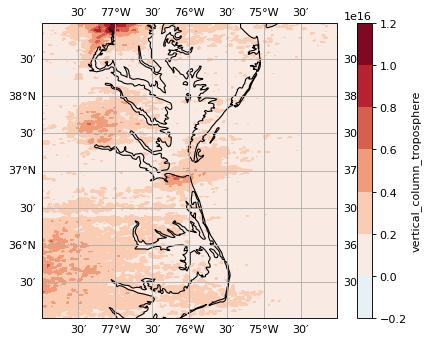

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

mean_vertical_column_trop.squeeze().plot.contourf(ax=ax)

# Add geographic features
ax.coastlines()
ax.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
)
plt.show()

In [ ]:
# Define spatial mean (average over longitude/latitude) calculation
spatial_mean_ds = (
    result_merged.sel(
        {
            "longitude": slice(lon_bounds[0], lon_bounds[1]),
            "latitude": slice(lat_bounds[0], lat_bounds[1]),
        }
    )
    .where(result_merged["main_data_quality_flag"] == 0)  # Filter for good quality data
    .mean(dim=("longitude", "latitude"))
)
spatial_mean_ds

<xarray.Dataset> Size: 416B
Dimensions:                                  (time: 8)
Coordinates:
  * time                                     (time) datetime64[ns] 64B 2024-0...
Data variables:
    weight                                   (time) float32 32B dask.array<chunksize=(1,), meta=np.ndarray>
    main_data_quality_flag                   (time) float32 32B dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_troposphere              (time) float64 64B dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (time) float64 64B dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_stratosphere             (time) float64 64B dask.array<chunksize=(1,), meta=np.ndarray>
    solar_zenith_angle                       (time) float32 32B dask.array<chunksize=(1,), meta=np.ndarray>
    viewing_zenith_angle                     (time) float32 32B dask.array<chunksize=(1,), meta=np.ndarray>
    relative_azimuth_angle                   (time) float32 32B dask.array<chunksize=(1,), meta=np.ndarray>

In [ ]:
%%time
# Compute the spatial mean
spatial_mean_vertical_column_trop = spatial_mean_ds[
    "vertical_column_troposphere"
].compute()

CPU times: user 1.43 s, sys: 120 ms, total: 1.55 s
Wall time: 10.5 s


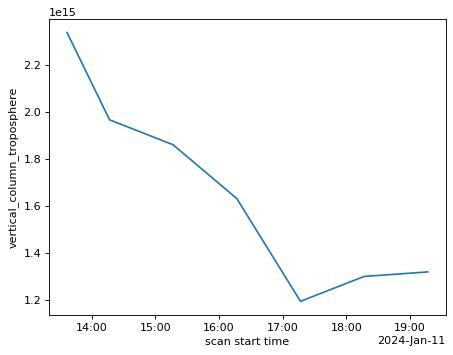

In [ ]:
spatial_mean_vertical_column_trop.plot()
plt.show()

In [ ]:
# Select a single scan time for detailed analysis
scan_time_start = np.datetime64("2024-01-11T13:00:00")  # 1 PM UTC
scan_time_end = np.datetime64("2024-01-11T14:00:00")  # 2 PM UTC

print(f"Analyzing single scan: {scan_time_start} to {scan_time_end} UTC")
print("Note: This corresponds to ~8-9 AM local time on the US East Coast")

subset_ds = result_merged.sel(
    {
        "longitude": slice(lon_bounds[0], lon_bounds[1]),
        "latitude": slice(lat_bounds[0], lat_bounds[1]),
        "time": slice(scan_time_start, scan_time_end),
    }
).where(result_merged["main_data_quality_flag"] == 0)
subset_ds

Analyzing single scan: 2024-01-11T13:00:00 to 2024-01-11T14:00:00 UTC
Note: This corresponds to ~8-9 AM local time on the US East Coast


<xarray.Dataset> Size: 2MB
Dimensions:                                  (latitude: 200, longitude: 200,
                                              time: 1)
Coordinates:
  * longitude                                (longitude) float32 800B -77.99 ...
  * latitude                                 (latitude) float32 800B 35.01 .....
  * time                                     (time) datetime64[ns] 8B 2024-01...
Data variables:
    weight                                   (latitude, longitude, time) float32 160kB dask.array<chunksize=(130, 150, 1), meta=np.ndarray>
    main_data_quality_flag                   (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    vertical_column_troposphere              (time, latitude, longitude) float64 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    vertical_column_stratosphere             (time, latitude, longitude) float64 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    solar_zenith_angle                       (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    viewing_zenith_angle                     (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    relative_azimuth_angle                   (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes: (12/40)
    history:                          2024-08-10T19:20:11Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2024-01-11T12:56:25Z
    time_coverage_end:                2024-01-11T13:36:11Z
    time_coverage_start_since_epoch:  1389013003.147965
    time_coverage_end_since_epoch:    1389015389.7366676
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 3 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [ ]:
%%time
# Compute the single scan's values
subset_vertical_column_trop = subset_ds["vertical_column_troposphere"].compute()

CPU times: user 287 ms, sys: 31.1 ms, total: 318 ms
Wall time: 2.82 s


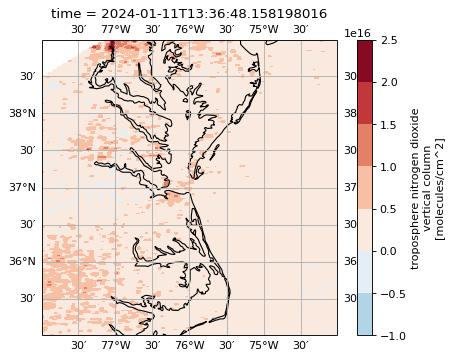

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

subset_vertical_column_trop.squeeze().plot.contourf(ax=ax)

# Add geographic features
ax.coastlines()
ax.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
)
plt.show()

# tolnet

In [ ]:
import requests
from getpass import getpass

# Credenciais EarthData
username = ""
password = getpass("Senha EarthData: ")

# Inicia sessão e configura autenticação básica HTTP
session = requests.Session()
session.auth = (username, password)


Senha EarthData: ··········


In [ ]:
pip install tolnet_v01

ERROR: Could not find a version that satisfies the requirement tolnet_v01 (from versions: none)
ERROR: No matching distribution found for tolnet_v01


In [ ]:
from tolnet_v01 import TOLNet

tolnet = TOLNet()  # cliente que encapsula autenticação e acesso à API

# Parâmetros de busca
min_date = "2023-07-12"
max_date = "2023-07-13"
# Em vez de especificar instrument_group e product_type, podemos filtrar por localização
lat, lon = 39.0, -76.8
radius_km = 100  # buscar estações até 100 km ao redor

# Usar o método `query_data` do módulo
results = tolnet.query_data(
    min_date = min_date,
    max_date = max_date,
    latitude = lat,
    longitude = lon,
    radius = radius_km,
    product_type = None,       # ou um ID válido de produto que desejamos (4 para hi-res, por exemplo)
    instrument_group = None
)

# results é uma lista de objetos (ou dicionários) com metadados e dados
for rec in results:
    print(rec.keys())
    # exibir parte dos dados
    print("ID:", rec.get("id"))
    print("Data início:", rec.get("data_date"))
    print("Altitudes:", rec.get("altitude")[:5], "…")
    print("O3 perfil (primeiras altitudes):", rec.get("o3")[:5], "…")


ModuleNotFoundError: No module named 'tolnet_v01'

# Task
Plot the `vertical_column_troposphere` variable for the location 34.0522, -118.2437 on 2025-01-01 using the TEMPO NO₂ L3 V03 dataset, count the number of empty values in the variable, and filter out data where `main_data_quality_flag` is not equal to 0.

## Buscar dados

### Subtask:
Utilizar a função `earthaccess.search_data` para encontrar os arquivos TEMPO NO₂ L3 V03 para a data de 01/01/2025.


**Reasoning**:
Use earthaccess.search_data to find the TEMPO NO2 L3 V03 granules for 2025-01-01.



In [ ]:
results = earthaccess.search_data(
    short_name="TEMPO_NO2_L3",
    version="V03",
    temporal=("2025-01-01 00:00", "2025-01-01 23:59"),
    count=100,
)

print(f"Number of granules found: {len(results)}")

Number of granules found: 13


## Abrir o dataset virtual

### Subtask:
Utilizar `earthaccess.open_virtual_mfdataset` para abrir os arquivos encontrados como um dataset virtual.


**Reasoning**:
Open the virtual dataset using earthaccess.open_virtual_mfdataset with the found granules and specified open options.



**Reasoning**:
The previous attempt failed because `open_options` was not defined in the current session. Need to redefine it before calling `open_virtual_mfdataset`.



In [ ]:
open_options = {
    "access": "indirect",  # access to cloud data (faster in AWS with "direct")
    "load": True,  # Load metadata immediately (required for indexing)
    "concat_dim": "time",  # Concatenate files along the time dimension
    "data_vars": "minimal",  # Only load data variables that include the concat_dim
    "coords": "minimal",  # Only load coordinate variables that include the concat_dim
    "compat": "override",  # Avoid coordinate conflicts by picking the first
    "combine_attrs": "override",  # Avoid attribute conflicts by picking the first
}

ds_virtual = earthaccess.open_virtual_mfdataset(granules=results, **open_options)
print(ds_virtual)

<xarray.Dataset> Size: 91MB
Dimensions:    (latitude: 2950, longitude: 7750, time: 13)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 104B 2025-01-01T12:48:20.024286464 ... 2...
Data variables:
    weight     (latitude, longitude) float32 91MB ...
Attributes: (12/40)
    history:                          2025-01-01T18:55:51Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2025-01-01T12:48:02Z
    time_coverage_end:                2025-01-01T13:27:51Z
    time_coverage_start_since_epoch:  1419770900.0242865
    time_coverage_end_since_epoch:    1419773289.6518493
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keyw

## Subselecionar a localização e data

### Subtask:
Filtrar o dataset virtual (`ds_virtual`) para a latitude 34.0522 e longitude -118.2437, e para a data de 01/01/2025.


**Reasoning**:
Define the latitude, longitude, and time range, then use .sel() to filter the virtual dataset and print the result.



**Reasoning**:
The previous command failed because the exact latitude value was not found in the dataset index. I need to use the `method='nearest'` argument in `.sel()` to select the nearest data point to the specified latitude and longitude.



In [ ]:
latitude = 34.0522
longitude = -118.2437
start_date = "2025-01-01 00:00"
end_date = "2025-01-01 23:59"

ds_subset = ds_virtual.sel(
    latitude=latitude,
    longitude=longitude,
    time=slice(start_date, end_date),
    method='nearest'
)

print(ds_subset)

NotImplementedError: cannot use ``method`` argument if any indexers are slice objects

**Reasoning**:
The previous command failed because using `method='nearest'` is not allowed when slicing the time dimension. I need to select the nearest latitude and longitude first and then slice the time dimension in a separate step.



In [ ]:
latitude = 34.0522
longitude = -118.2437
start_date = "2025-01-01 00:00"
end_date = "2025-01-01 23:59"

ds_subset_location = ds_virtual.sel(
    latitude=latitude,
    longitude=longitude,
    method='nearest'
)

ds_subset = ds_subset_location.sel(time=slice(start_date, end_date))

print(ds_subset)

<xarray.Dataset> Size: 116B
Dimensions:    (time: 13)
Coordinates:
    longitude  float32 4B -118.2
    latitude   float32 4B 34.05
  * time       (time) datetime64[ns] 104B 2025-01-01T12:48:20.024286464 ... 2...
Data variables:
    weight     float32 4B ...
Attributes: (12/40)
    history:                          2025-01-01T18:55:51Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2025-01-01T12:48:02Z
    time_coverage_end:                2025-01-01T13:27:51Z
    time_coverage_start_since_epoch:  1419770900.0242865
    time_coverage_end_since_epoch:    1419773289.6518493
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 3 files provide 

## Filtrar dados de baixa qualidade

### Subtask:
Aplicar o filtro `main_data_quality_flag == 0` ao dataset subsetado (`ds_subset`) para remover dados de baixa qualidade.


**Reasoning**:
Apply the quality flag filter to the subsetted dataset.



In [ ]:
ds_filtered = ds_subset.where(ds_subset['main_data_quality_flag'] == 0)
print(ds_filtered)

KeyError: "No variable named 'main_data_quality_flag'. Variables on the dataset include ['weight', 'longitude', 'latitude', 'time']"

**Reasoning**:
The previous attempt failed because the variable 'main_data_quality_flag' was not present in the subsetted dataset. This likely happened because the data_vars option was set to 'minimal' when opening the virtual dataset, and 'main_data_quality_flag' might not include the 'time' dimension. Re-open the virtual dataset with data_vars set to 'all' to include all variables, then subset and filter.



In [ ]:
open_options_all = {
    "access": "indirect",
    "load": True,
    "concat_dim": "time",
    "data_vars": "all",  # Include all data variables
    "coords": "minimal",
    "compat": "override",
    "combine_attrs": "override",
}

ds_virtual_all = earthaccess.open_virtual_mfdataset(granules=results, **open_options_all)

latitude = 34.0522
longitude = -118.2437
start_date = "2025-01-01 00:00"
end_date = "2025-01-01 23:59"

ds_subset_location_all = ds_virtual_all.sel(
    latitude=latitude,
    longitude=longitude,
    method='nearest'
)

ds_subset_all = ds_subset_location_all.sel(time=slice(start_date, end_date))

ds_filtered = ds_subset_all.where(ds_subset_all['main_data_quality_flag'] == 0)
print(ds_filtered)

KeyError: "No variable named 'main_data_quality_flag'. Variables on the dataset include ['weight', 'longitude', 'latitude', 'time']"

**Reasoning**:
The variable 'main_data_quality_flag' is still not available in the dataset even after trying to load all variables. It is possible that this variable is located in a different group within the NetCDF file. The previous successful attempt to access NO2 data in the notebook (cell 4Ip3z8CHtc5F) merged data from different groups ('root', 'product', 'geolocation'). We should try merging the datasets from these groups after opening them virtually.



In [ ]:
open_options = {
    "access": "indirect",
    "load": True,
    "concat_dim": "time",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "combine_attrs": "override",
}

result_root = earthaccess.open_virtual_mfdataset(granules=results, **open_options)
result_product = earthaccess.open_virtual_mfdataset(
    granules=results, group="product", **open_options
)
result_geolocation = earthaccess.open_virtual_mfdataset(
    granules=results, group="geolocation", **open_options
)
# merge
result_merged = xr.merge([result_root, result_product, result_geolocation])

latitude = 34.0522
longitude = -118.2437
start_date = "2025-01-01 00:00"
end_date = "2025-01-01 23:59"

ds_subset_location = result_merged.sel(
    latitude=latitude,
    longitude=longitude,
    method='nearest'
)

ds_subset = ds_subset_location.sel(time=slice(start_date, end_date))

ds_filtered = ds_subset.where(ds_subset['main_data_quality_flag'] == 0)
print(ds_filtered)

<xarray.Dataset> Size: 684B
Dimensions:                                  (time: 13)
Coordinates:
    longitude                                float32 4B -118.2
    latitude                                 float32 4B 34.05
  * time                                     (time) datetime64[ns] 104B 2025-...
Data variables:
    weight                                   (time) float32 52B dask.array<chunksize=(1,), meta=np.ndarray>
    main_data_quality_flag                   (time) float32 52B dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_troposphere              (time) float64 104B dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (time) float64 104B dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_stratosphere             (time) float64 104B dask.array<chunksize=(1,), meta=np.ndarray>
    solar_zenith_angle                       (time) float32 52B dask.array<chunksize=(1,), meta=np.ndarray>
    viewing_zenith_angle      

## Calcular e contar valores vazios

### Subtask:
Calcular a quantidade de valores vazios (`NaN`) na variável `vertical_column_troposphere` para a seleção feita no dataset filtrado `ds_filtered`.


**Reasoning**:
Calculate the number of NaN values in the 'vertical_column_troposphere' variable of the filtered dataset.



In [ ]:
nan_count = ds_filtered['vertical_column_troposphere'].isnull().sum().compute()
print(f"Número de valores vazios (NaN) na variável vertical_column_troposphere: {nan_count}")

Número de valores vazios (NaN) na variável vertical_column_troposphere: <xarray.DataArray 'vertical_column_troposphere' ()> Size: 8B
array(5)
Coordinates:
    longitude  float32 4B -118.2
    latitude   float32 4B 34.05


## Plotar os dados

### Subtask:
Gerar um plot da variável `vertical_column_troposphere` para a localização e data especificadas no dataset filtrado `ds_filtered`.


**Reasoning**:
Access the 'vertical_column_troposphere' variable from the filtered dataset and plot it.



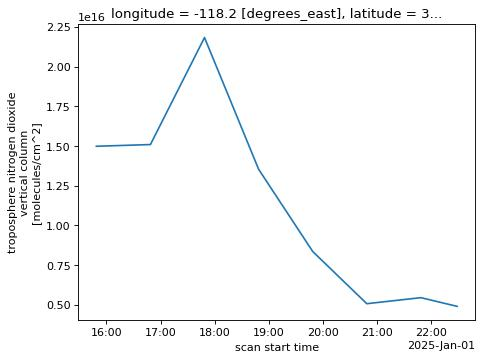

In [ ]:
ds_filtered['vertical_column_troposphere'].plot()
plt.show()

## Exibir resultados

### Subtask:
Apresentar a contagem de valores vazios e o plot gerado.


**Reasoning**:
Print the `nan_count` variable to display the number of empty values found.



In [ ]:
print(f"Número de valores vazios (NaN) na variável vertical_column_troposphere: {nan_count}")

Número de valores vazios (NaN) na variável vertical_column_troposphere: <xarray.DataArray 'vertical_column_troposphere' ()> Size: 8B
array(5)
Coordinates:
    longitude  float32 4B -118.2
    latitude   float32 4B 34.05


## Summary:

### Data Analysis Key Findings

*   13 granules were found for the specified criteria (TEMPO NO₂ L3 V03 data for 2025-01-01).
*   The dataset was successfully subsetted to the nearest location to 34.0522, -118.2437 for the date 2025-01-01.
*   Filtering the data based on `main_data_quality_flag == 0` successfully removed data points where the quality flag was not 0.
*   After filtering by location, date, and data quality, there were 5 empty values (NaN) found in the `vertical_column_troposphere` variable.

### Insights or Next Steps

*   The `main_data_quality_flag` variable resides in the 'product' group of the NetCDF files and needs to be explicitly accessed and merged with other groups to be used for filtering.
*   The plot of `vertical_column_troposphere` for the specified location and date provides a visual representation of the data quality and availability after filtering.


In [5]:
import requests
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

MISSING = -999.0

def grau_para_cardinal(g):
    pontos = ["N","NNE","NE","ENE","E","ESE","SE","SSE",
              "S","SSW","SW","WSW","W","WNW","NW","NNW"]
    g = (g % 360 + 360) % 360
    idx = int((g + 11.25) // 22.5) % 16
    return pontos[idx]

def wd2m_ultimos7dias(lat, lon, vel_min=0.5, usar_utc=True):
    tz_user = ZoneInfo("America/Sao_Paulo")
    hoje = datetime.now(tz_user).date()
    inicio = (hoje - timedelta(days=7)).strftime("%Y%m%d")
    fim = hoje.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "WD2M,WS2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    wd = js["properties"]["parameter"].get("WD2M", {})
    ws = js["properties"]["parameter"].get("WS2M", {})

    resultados = []
    for hora in sorted(wd.keys()):
        wd_val = wd[hora]
        ws_val = ws.get(hora, MISSING)
        if wd_val != MISSING and ws_val != MISSING and ws_val >= vel_min:
            resultados.append({
                "data_hora": hora,                       # formato YYYYMMDDHH
                "time_standard": "UTC" if usar_utc else "LST",
                "direcao_graus": float(wd_val),
                "direcao_cardinal": grau_para_cardinal(float(wd_val)),
                "vel_vento_ms": float(ws_val)
            })

    return {
        "lat": lat, "lon": lon,
        "periodo": f"{inicio} a {fim}",
        "total_horas_validas": len(resultados),
        "dados": resultados
    }

# Exemplo de uso: São Paulo
if __name__ == "__main__":
    lat, lon = -23.55, -46.63
    dados = wd2m_ultimos7dias(lat, lon)
    print(dados)


{'lat': -23.55, 'lon': -46.63, 'periodo': '20250927 a 20251004', 'total_horas_validas': 139, 'dados': [{'data_hora': '2025092700', 'time_standard': 'UTC', 'direcao_graus': 135.5, 'direcao_cardinal': 'SE', 'vel_vento_ms': 2.28}, {'data_hora': '2025092701', 'time_standard': 'UTC', 'direcao_graus': 130.8, 'direcao_cardinal': 'SE', 'vel_vento_ms': 2.22}, {'data_hora': '2025092702', 'time_standard': 'UTC', 'direcao_graus': 130.2, 'direcao_cardinal': 'SE', 'vel_vento_ms': 2.11}, {'data_hora': '2025092703', 'time_standard': 'UTC', 'direcao_graus': 132.2, 'direcao_cardinal': 'SE', 'vel_vento_ms': 2.01}, {'data_hora': '2025092704', 'time_standard': 'UTC', 'direcao_graus': 127.1, 'direcao_cardinal': 'SE', 'vel_vento_ms': 1.91}, {'data_hora': '2025092705', 'time_standard': 'UTC', 'direcao_graus': 113.8, 'direcao_cardinal': 'ESE', 'vel_vento_ms': 1.84}, {'data_hora': '2025092706', 'time_standard': 'UTC', 'direcao_graus': 102.8, 'direcao_cardinal': 'ESE', 'vel_vento_ms': 1.67}, {'data_hora': '20250

# POWER

## Temperatura a 2M

### horas

In [7]:
import requests
import csv
from datetime import datetime, timedelta, timezone

MISSING = -999.0  # flag de ausência no POWER

def salvar_t2m_90h_csv(lat=34.0522, lon=-118.2437, usar_utc=True):
    agora_utc = datetime.now(timezone.utc)
    inicio = (agora_utc - timedelta(days=4)).strftime("%Y%m%d")
    fim = agora_utc.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "T2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    serie = js["properties"]["parameter"].get("T2M", {})

    # Ordena timestamps e pega últimos 90
    chaves_ordenadas = sorted(serie.keys())
    ultimas_90 = chaves_ordenadas[-90:] if len(chaves_ordenadas) > 90 else chaves_ordenadas

    # Salva em CSV
    with open("t2m_hours.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "t2m"])  # cabeçalho
        for k in ultimas_90:
            val = float(serie[k])
            writer.writerow([k, val])

    print(f"Arquivo 't2m_hours.csv' salvo com {len(ultimas_90)} linhas.")

# Executar
if __name__ == "__main__":
    salvar_t2m_90h_csv()


Arquivo 't2m_hours.csv' salvo com 90 linhas.


### dias

In [8]:
import requests
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict

MISSING = -999.0

def salvar_t2m_days_csv(lat=34.0522, lon=-118.2437, dias=40, usar_utc=True):
    agora_utc = datetime.now(timezone.utc)
    inicio_dt = (agora_utc - timedelta(days=dias))
    inicio = inicio_dt.strftime("%Y%m%d")
    fim = agora_utc.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "T2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    serie = js["properties"]["parameter"].get("T2M", {})

    soma_por_dia = defaultdict(float)
    cont_por_dia = defaultdict(int)

    for ts, val in serie.items():
        dia = ts[:8]
        v = float(val)
        if v != MISSING:
            soma_por_dia[dia] += v
            cont_por_dia[dia] += 1


    dias_ordenados = sorted(d for d in soma_por_dia.keys())
    if len(dias_ordenados) > dias:
        dias_ordenados = dias_ordenados[-dias:]

    linhas = []
    for d in dias_ordenados:
        n = cont_por_dia[d]
        if n > 0:
            media = soma_por_dia[d] / n
            linhas.append((d, f"{media:.3f}"))

    with open("t2m_days.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["date", "t2m_mean"])
        w.writerows(linhas)

    print(f"{len(linhas)} linhas")

if __name__ == "__main__":
    salvar_t2m_days_csv()


Arquivo 't2m_days.csv' salvo com 39 linhas (dias com pelo menos 1 valor válido).


## umidade a 2M

### horas

In [9]:
import requests
import csv
from datetime import datetime, timedelta, timezone

MISSING = -999.0  # flag de ausência no POWER

def salvar_rh_90h_csv(lat=34.0522, lon=-118.2437, usar_utc=True):
    """
    Busca os últimos ~4 dias de dados horários de RH2M e salva as últimas 90 horas em rh_hours.csv.
    CSV com colunas: timestamp (YYYYMMDDHH) e rh2m (%).
    """
    agora_utc = datetime.now(timezone.utc)
    inicio = (agora_utc - timedelta(days=4)).strftime("%Y%m%d")
    fim = agora_utc.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "RH2M",           # Umidade relativa a 2 m (%)
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    serie = js["properties"]["parameter"].get("RH2M", {})

    # ordena timestamps (YYYYMMDDHH) e pega as últimas 90 horas
    chaves_ordenadas = sorted(serie.keys())
    ultimas_90 = chaves_ordenadas[-90:] if len(chaves_ordenadas) > 90 else chaves_ordenadas

    # grava CSV com duas colunas: timestamp, rh2m
    with open("rh_hours.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["timestamp", "rh2m"])
        for k in ultimas_90:
            val = float(serie[k])
            w.writerow([k, val])

    print(f"Arquivo 'rh_hours.csv' salvo com {len(ultimas_90)} linhas.")

# Executar diretamente
if __name__ == "__main__":
    salvar_rh_90h_csv()


Arquivo 'rh_hours.csv' salvo com 90 linhas.


### dias

In [10]:
import requests
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict

MISSING = -999.0

def salvar_RH2M_days_csv(lat=34.0522, lon=-118.2437, dias=40, usar_utc=True):
    agora_utc = datetime.now(timezone.utc)
    inicio_dt = (agora_utc - timedelta(days=dias))
    inicio = inicio_dt.strftime("%Y%m%d")
    fim = agora_utc.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "RH2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    serie = js["properties"]["parameter"].get("RH2M", {})

    soma_por_dia = defaultdict(float)
    cont_por_dia = defaultdict(int)

    for ts, val in serie.items():
        dia = ts[:8]
        v = float(val)
        if v != MISSING:
            soma_por_dia[dia] += v
            cont_por_dia[dia] += 1


    dias_ordenados = sorted(d for d in soma_por_dia.keys())
    if len(dias_ordenados) > dias:
        dias_ordenados = dias_ordenados[-dias:]

    linhas = []
    for d in dias_ordenados:
        n = cont_por_dia[d]
        if n > 0:
            media = soma_por_dia[d] / n
            linhas.append((d, f"{media:.3f}"))

    with open("RH2M_days.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["date", "RH2M_mean"])
        w.writerows(linhas)

    print(f"{len(linhas)} linhas")

if __name__ == "__main__":
    salvar_RH2M_days_csv()


39 linhas


### velocidade vento

In [11]:
import requests
import csv
from datetime import datetime, timedelta, timezone

MISSING = -999.0  # flag de ausência no POWER

def salvar_ws_90h_csv(lat=34.0522, lon=-118.2437, usar_utc=True):
    """
    Busca os últimos ~4 dias de dados horários de WS2M e salva as últimas 90 horas em ws_hours.csv.
    CSV com colunas: timestamp (YYYYMMDDHH) e ws2m (m/s).
    """
    agora_utc = datetime.now(timezone.utc)
    inicio = (agora_utc - timedelta(days=4)).strftime("%Y%m%d")
    fim = agora_utc.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "WS2M",           # Velocidade do vento a 2 m (m/s)
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    serie = js["properties"]["parameter"].get("WS2M", {})

    # ordena timestamps (YYYYMMDDHH) e pega as últimas 90 horas
    chaves_ordenadas = sorted(serie.keys())
    ultimas_90 = chaves_ordenadas[-90:] if len(chaves_ordenadas) > 90 else chaves_ordenadas

    # grava CSV com duas colunas: timestamp, ws2m
    with open("ws_hours.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["timestamp", "ws2m"])
        for k in ultimas_90:
            val = float(serie[k])
            w.writerow([k, val])

    print(f"Arquivo 'ws_hours.csv' salvo com {len(ultimas_90)} linhas.")

# Executar diretamente
if __name__ == "__main__":
    salvar_ws_90h_csv()


Arquivo 'ws_hours.csv' salvo com 90 linhas.


### dias

In [12]:
import requests
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict

MISSING = -999.0  # flag de ausência no POWER

def salvar_ws_days_csv(lat=34.0522, lon=-118.2437, dias=40, usar_utc=True):
    """
    Busca WS2M horário nos últimos `dias`, agrega por dia (média) e salva em ws_days.csv.
    - date: YYYYMMDD (UTC ou LST)
    - ws2m_mean: média diária (m/s), ignorando -999.0
    """
    agora_utc = datetime.now(timezone.utc)
    inicio_dt = (agora_utc - timedelta(days=dias))
    inicio = inicio_dt.strftime("%Y%m%d")
    fim = agora_utc.strftime("%Y%m%d")

    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "WS2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": inicio,
        "end": fim,
        "format": "JSON",
        "time-standard": "UTC" if usar_utc else "LST",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()

    serie = js["properties"]["parameter"].get("WS2M", {})

    soma_por_dia = defaultdict(float)
    cont_por_dia = defaultdict(int)

    for ts, val in serie.items():
        dia = ts[:8]  # pega YYYYMMDD
        v = float(val)
        if v != MISSING:
            soma_por_dia[dia] += v
            cont_por_dia[dia] += 1

    dias_ordenados = sorted(soma_por_dia.keys())
    if len(dias_ordenados) > dias:
        dias_ordenados = dias_ordenados[-dias:]

    linhas = []
    for d in dias_ordenados:
        n = cont_por_dia[d]
        if n > 0:
            media = soma_por_dia[d] / n
            linhas.append((d, f"{media:.3f}"))

    with open("ws_days.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["date", "ws2m_mean"])
        w.writerows(linhas)

    print(f"Arquivo 'ws_days.csv' salvo com {len(linhas)} linhas (dias válidos).")

# exemplo de uso
if __name__ == "__main__":
    salvar_ws_days_csv()


Arquivo 'ws_days.csv' salvo com 39 linhas (dias válidos).
